In [4]:
import numpy as np
import torch

c:\Users\zhufe\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\zhufe\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\zhufe\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\zhufe\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [5]:
import torch

PRIOR_LAMBDA = 1.0
PRIOR_SD = 1.0

def sample_exp(l):
    # Using exponential sampling from PyTorch
    return torch.distributions.Exponential(1.0/l).sample()

def sample_norm(mu, sd):
    # Using normal sampling from PyTorch
    return torch.distributions.Normal(mu, sd).sample()

def elbo_score(theta, x_samples, prior_lambda, prior_sd):
    elbo = torch.sum(x_samples) / (theta * prior_sd**2) 
    elbo -= 1 / ((theta**2) * (prior_sd**2))
    elbo -= prior_lambda / theta 
    elbo -= torch.log(theta) 
    return elbo

def elbo_optimal(x_samples, prior_lambda, prior_sd):
    a = 1
    b = torch.sum(x_samples) / (prior_sd**2) - prior_lambda
    c = -2/prior_sd**2
    return (-b + torch.sqrt(b**2 - 4*a*c)) / (2*a)

def true_posterior(z, x_samples, prior_lambda, prior_sd):
    exponent = torch.sum(-0.5 * ((x_samples - z) / prior_sd) ** 2) - prior_lambda * z
    return torch.exp(exponent)

In [6]:
TRUE_Z = sample_exp(PRIOR_LAMBDA)
TRUE_Z

tensor(0.5812)

In [7]:
NUM_SAMPLES = 100
x_samples = torch.tensor([sample_norm(TRUE_Z, PRIOR_SD) for _ in range(NUM_SAMPLES)])

In [8]:
ALPHA = 0.1
START_ESTIMATE = 3.0
theta_estimate = torch.tensor(START_ESTIMATE, requires_grad=True)
for _ in range(100):
    elbo = elbo_score(theta_estimate, x_samples, PRIOR_LAMBDA, PRIOR_SD)
    elbo.backward()
    theta_estimate.data += ALPHA*theta_estimate.grad
    theta_estimate.grad.zero_()
    
    # Ensuring theta_estimate remains positive
    if theta_estimate.data < 0:
        theta_estimate.data = torch.tensor(1e-4)  # setting to a small positive value
theta_optimal = elbo_optimal(x_samples, PRIOR_LAMBDA, PRIOR_SD)

In [9]:
print(f"{theta_estimate=}")
print(f"{theta_optimal=}")

theta_estimate=tensor(1.9939e+11, requires_grad=True)
theta_optimal=tensor(0.0329)


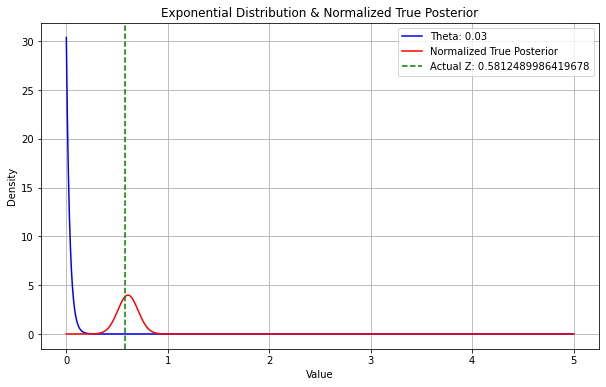

In [11]:
import torch
import matplotlib.pyplot as plt

# Generate data
x = torch.linspace(0, 5, 1000)  # Values from 0 to 5
y = (1/theta_optimal) * torch.exp(-x/theta_optimal)  # Exponential distribution formula

# Compute the posterior for each z value
posterior_values = torch.tensor([true_posterior(z, x_samples, PRIOR_LAMBDA, PRIOR_SD) for z in x])

# Numerically integrate and normalize the posterior
delta_z = x[1] - x[0]  # spacing between z_values
area_under_curve = torch.sum(posterior_values * delta_z)
normalized_posterior_values = posterior_values / area_under_curve

# Convert tensors to numpy arrays for plotting
x = x.detach().numpy()
y = y.detach().numpy()
normalized_posterior_values = normalized_posterior_values.detach().numpy()

# Plotting
plt.figure(figsize=(10,6))
plt.plot(x, y, label=f'Theta: {theta_optimal.item():.2f}', color='blue')
plt.plot(x, normalized_posterior_values, label="Normalized True Posterior", color='red')
plt.axvline(TRUE_Z, color='green', linestyle='--', label=f'Actual Z: {TRUE_Z}')
plt.title("Exponential Distribution & Normalized True Posterior")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
